# Importing libraries

In [61]:
import pandas as pd
import numpy as np
import json
# plotting
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch
# statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
#opening data
import os
import pathlib
import warnings

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

# Opening Data

In [62]:
notebook_dir = pathlib.Path().absolute()
events_path = os.path.join(notebook_dir.parent, "wyscout-data", "events", "events_England.json")

with open(events_path) as f:
    events = json.load(f)

df_events = pd.DataFrame(events)
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643150 entries, 0 to 643149
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   eventId       643150 non-null  int64  
 1   subEventName  643150 non-null  object 
 2   tags          643150 non-null  object 
 3   playerId      643150 non-null  int64  
 4   positions     643150 non-null  object 
 5   matchId       643150 non-null  int64  
 6   eventName     643150 non-null  object 
 7   teamId        643150 non-null  int64  
 8   matchPeriod   643150 non-null  object 
 9   eventSec      643150 non-null  float64
 10  subEventId    643150 non-null  object 
 11  id            643150 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 58.9+ MB


In [63]:
df_events.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175


# Preparing data

In [64]:
# Get all shots
shots = df_events[df_events["subEventName"] == 'Shot']

# Add new locations columns
shots["X"] = shots.positions.apply(lambda cell: (100 - cell[0]['x']) * 105/100)
shots["Y"] = shots.positions.apply(lambda cell: cell[0]['y'] * 68/100)
shots["C"] = shots.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * 68/100)    # Distance to the middle of the pitch

# Add column for distance and angle (radians)
shots["Distance"] = np.sqrt(shots["X"] ** 2 + shots["C"] ** 2)
shots["Angle"] = np.where(np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) > 0, np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)), np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) + np.pi)

# If it's a goal, {'id': 101} is in the tags column
shots["Goal"] = shots.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(object)
shots.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8451 entries, 46 to 643149
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   eventId       8451 non-null   int64  
 1   subEventName  8451 non-null   object 
 2   tags          8451 non-null   object 
 3   playerId      8451 non-null   int64  
 4   positions     8451 non-null   object 
 5   matchId       8451 non-null   int64  
 6   eventName     8451 non-null   object 
 7   teamId        8451 non-null   int64  
 8   matchPeriod   8451 non-null   object 
 9   eventSec      8451 non-null   float64
 10  subEventId    8451 non-null   object 
 11  id            8451 non-null   int64  
 12  X             8451 non-null   float64
 13  Y             8451 non-null   float64
 14  C             8451 non-null   float64
 15  Distance      8451 non-null   float64
 16  Angle         8451 non-null   float64
 17  Goal          8451 non-null   object 
dtypes: float64(6), int64(5), objec

# Plotting shot location

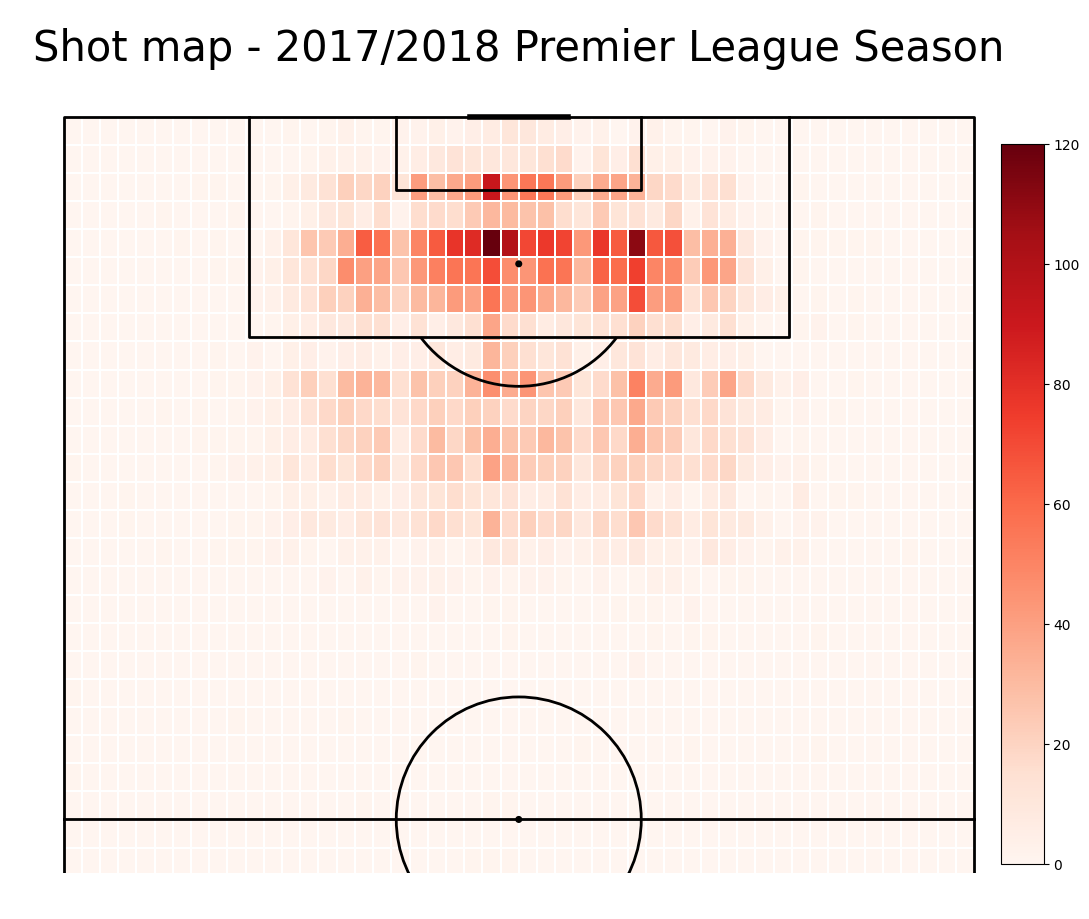

In [65]:
# Plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# Calculate number of shots in each bin
# Subtracting x from 105 but not y from 68 because of inverted Wyscout axis
bin_statistic_shots = pitch.bin_statistic(105 - shots.X, shots.Y, bins=50)

# Make heatmap
pcm = pitch.heatmap(bin_statistic_shots, ax=ax["pitch"], cmap='Reds', edgecolor='white', linewidth = 0.01)

# Make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle('Shot map - 2017/2018 Premier League Season' , fontsize = 30)
plt.show()

# Plotting goal location

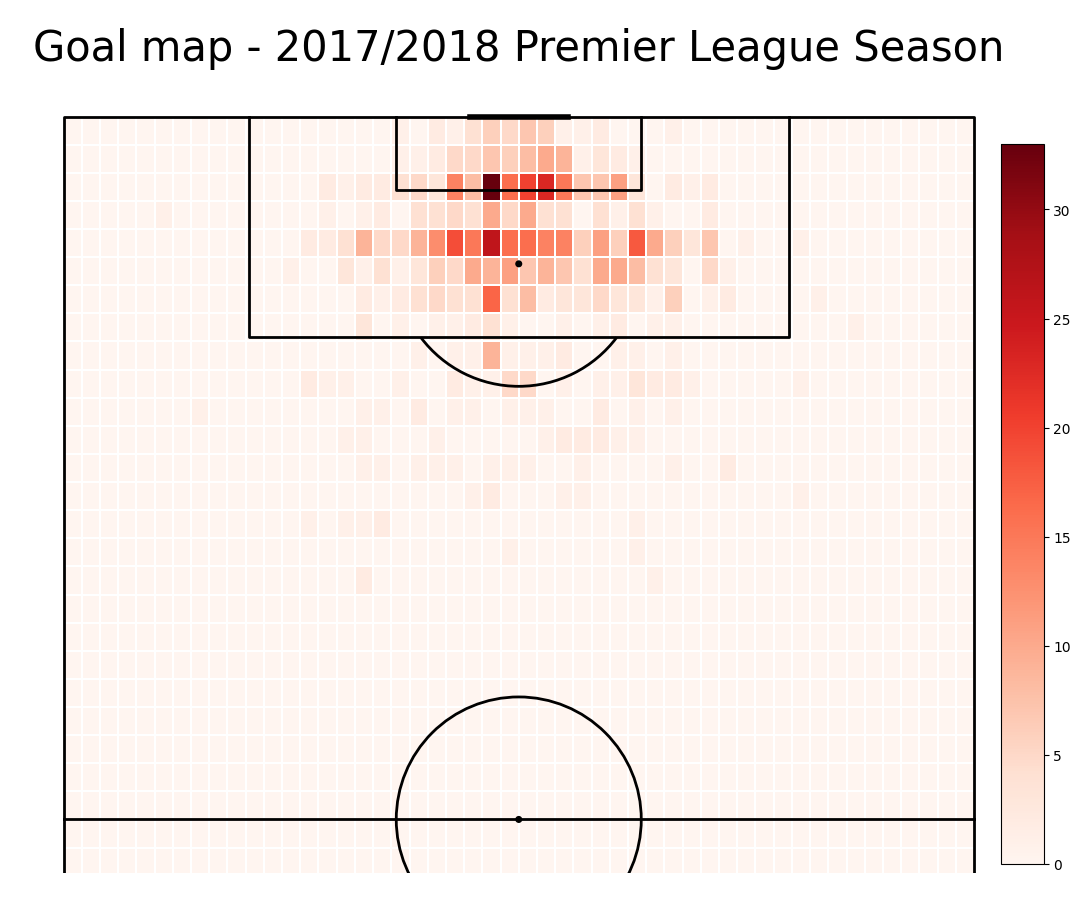

In [66]:
# Only use the goals
goals = shots[shots["Goal"] == 1]

# Plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# Calculate number of goals in each bin
# Subtracting x from 105 but not y from 68 because of inverted Wyscout axis
bin_statistic_goals = pitch.bin_statistic(105 - goals.X, goals.Y, bins=50)

# Make heatmap
pcm = pitch.heatmap(bin_statistic_goals, ax=ax["pitch"], cmap='Reds', edgecolor='white', linewidth = 0.01)

# Make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle('Goal map - 2017/2018 Premier League Season' , fontsize = 30)
plt.show()

# Plotting probability of scoring a goal given the location

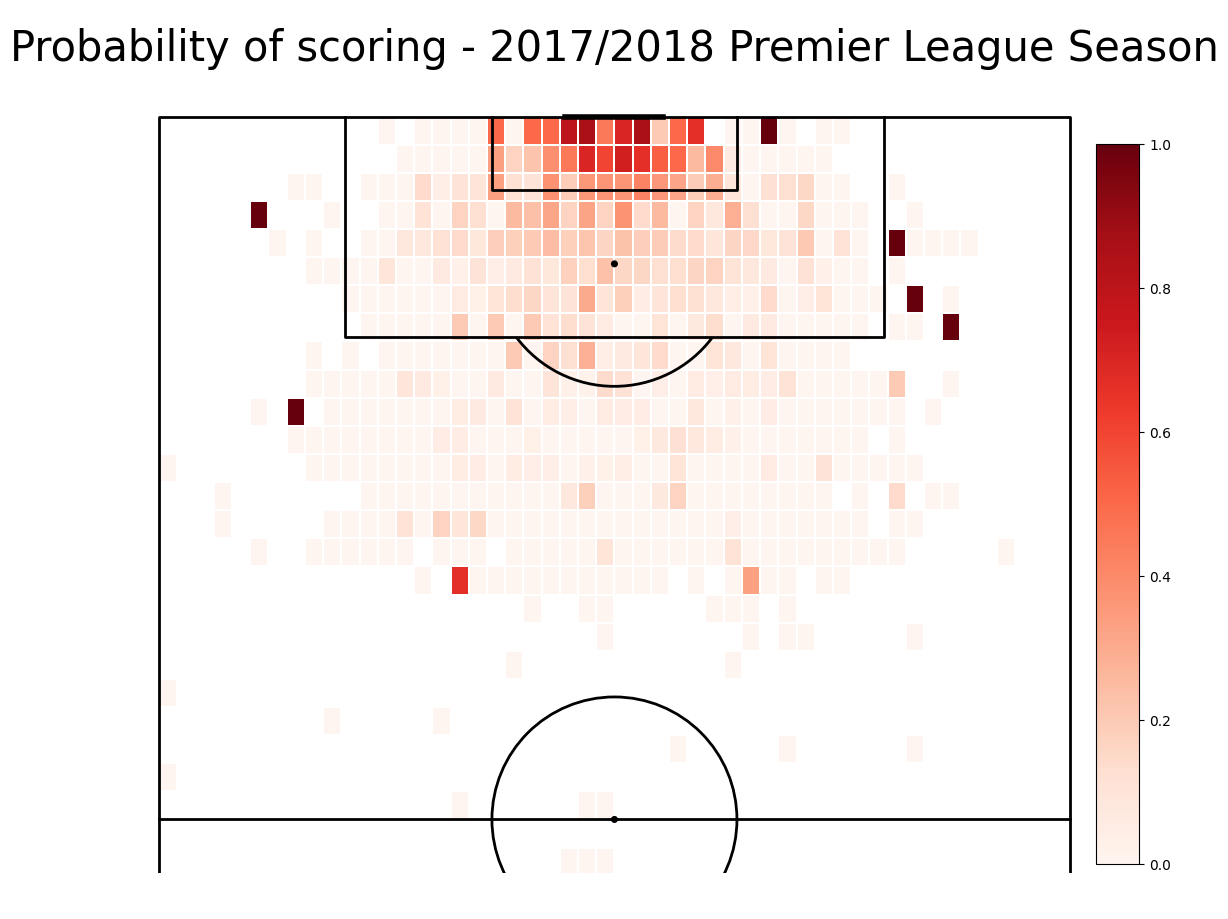

In [67]:
# Plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

bin_statistic = pitch.bin_statistic(105 - shots.X, shots.Y, bins=50)

# Normalize number of goals by number of shots
bin_statistic["statistic"] = bin_statistic_goals["statistic"] / bin_statistic["statistic"]

# Make heatmap
pcm = pitch.heatmap(bin_statistic, ax=ax["pitch"], cmap='Reds', edgecolor='white', linewidth = 0.01)

# Make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle('Probability of scoring - 2017/2018 Premier League Season' , fontsize = 30)
plt.show()

# Plotting logistic curve

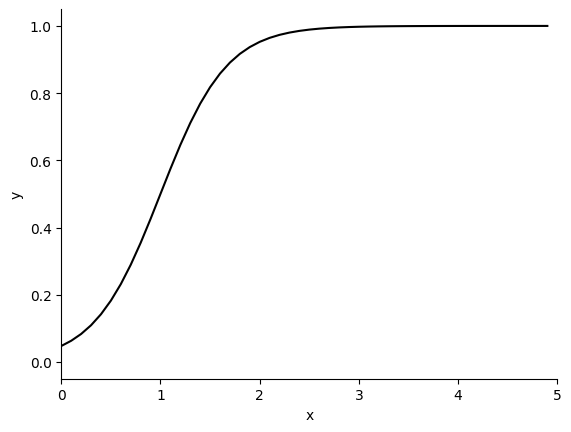

In [68]:
b = [3, -3]

x = np.arange(5, step=0.1)
y = 1/(1+np.exp(b[0]+b[1]*x)) # logistic function

fig,ax = plt.subplots()
plt.ylim((-0.05,1.05))
plt.xlim((0,5))
ax.set_ylabel('y')
ax.set_xlabel("x")
ax.plot(x, y, linestyle='solid', color='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# Investigate relationship between goals and angle

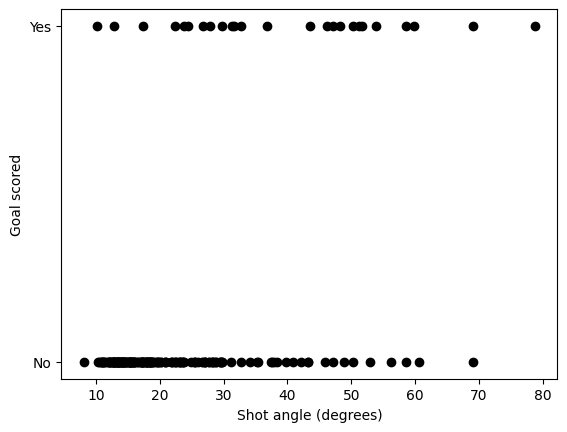

In [69]:
# Take first 200 shots
shots_200 = shots.iloc[:200]
shots_200.head()

# Plot the goal angle of the first 200 shots
fig, ax = plt.subplots()
ax.plot(shots_200['Angle']*180/np.pi, shots_200['Goal'], linestyle='none', marker= '.', markersize= 12, color='black')

#make legend
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
ax.set_yticks([0,1])
ax.set_yticklabels(['No','Yes'])
plt.show()

# Investigate relationship between probability of scoring and angle

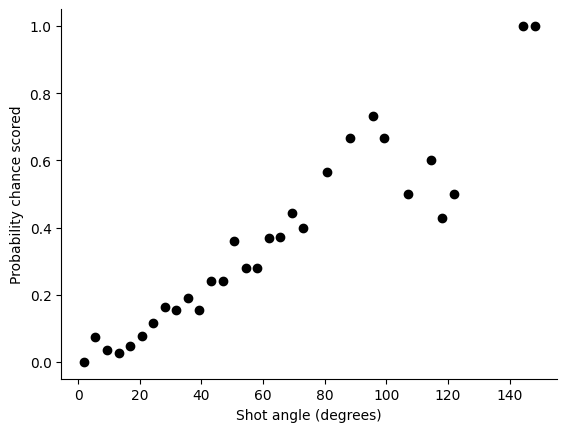

In [70]:
# Bin number of shots from angle
shotcount_dist = np.histogram(shots['Angle']*180/np.pi, bins=40, range=[0, 150])

# Bin number of goals from angle
goalcount_dist = np.histogram(goals['Angle']*180/np.pi, bins=40, range=[0, 150])

np.seterr(divide='ignore', invalid='ignore') # Surpresses warnings when dividing by 0 and invalid values

# Probability of scoring goal
prob_goal = np.divide(goalcount_dist[0], shotcount_dist[0]) # goalcount_dist[0] is the number of goals in each bin, shotcount_dist[0] is the number of shots in each bin
angle = shotcount_dist[1] # contains bin edges
midangle = (angle[:-1] + angle[1:])/2 # calculates middle point of each bin

# Make plot
fig,ax = plt.subplots()
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# Fitting logistic regression with random coefficients

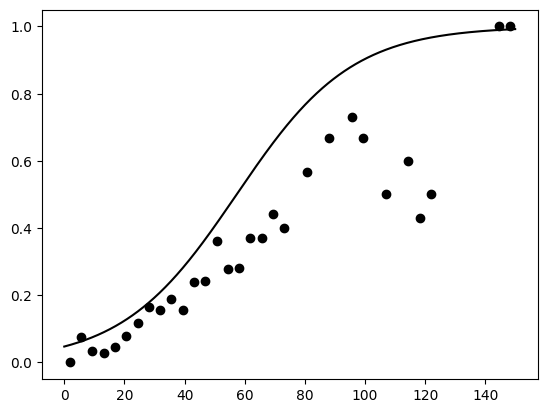

In [71]:
fig, ax = plt.subplots()

# Define coefficients
b = [3, -3]
x = np.arange(150,step=0.1)
y = 1/(1+np.exp(b[0]+b[1]*x*np.pi/180))

# Plot line
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')

# Plot logistic function
ax.plot(x, y, linestyle='solid', color='black')
plt.show()


# Log-likelihood

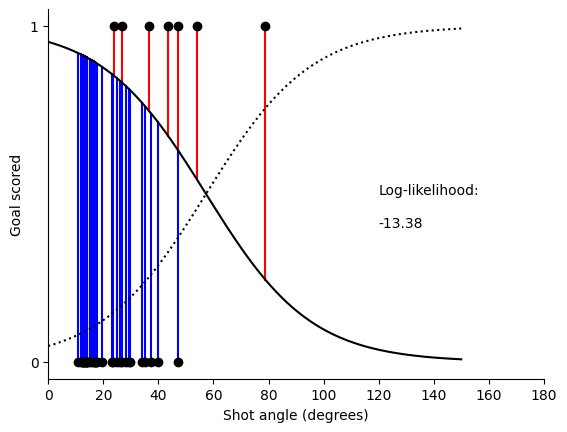

In [72]:
# Best coefficients are those which maximize the log likelihood

# Calculate xG
xG = 1/(1+np.exp(b[0]+b[1]*shots['Angle']))
shots = shots.assign(xG = xG)
shots_40 = shots.iloc[:40]

# Plot data
fig, ax = plt.subplots()
ax.plot(shots_40['Angle']*180/np.pi, shots_40['Goal'], linestyle='none', marker= '.', markersize= 12, color='black', zorder = 3)

# Plot curves
ax.plot(x, y, linestyle=':', color='black', zorder = 2)
ax.plot(x, 1-y, linestyle='solid', color='black', zorder = 2)

# Calculate log-likelihood
loglikelihood=0
for item,shot in shots_40.iterrows():
    ang = shot['Angle'] * 180/np.pi
    if shot['Goal'] == 1:
        loglikelihood = loglikelihood + np.log(shot['xG'])
        ax.plot([ang,ang],[shot['Goal'],1-shot['xG']], color='red', zorder = 1)
    else:
        loglikelihood = loglikelihood + np.log(1 - shot['xG'])
        ax.plot([ang,ang], [shot['Goal'], 1-shot['xG']], color='blue', zorder = 1)

# Make legend
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
plt.xlim((0,180))
plt.text(120,0.5,'Log-likelihood:')
plt.text(120,0.4,str(loglikelihood)[:6])
ax.set_yticks([0,1])

# Show plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# Fitting logistic regression and finding the best parameters

In [73]:
# Create model
test_model = smf.glm(formula="Goal ~ Angle" , data=shots, family=sm.families.Binomial()).fit()
print(test_model.summary())

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8451
Model:                                GLM   Df Residuals:                     8449
Model Family:                    Binomial   Df Model:                            1
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2561.2
Date:                    Sun, 04 May 2025   Deviance:                       5122.5
Time:                            16:50:52   Pearson chi2:                 7.96e+03
No. Iterations:                         6   Pseudo R-squ. (CS):            0.07609
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

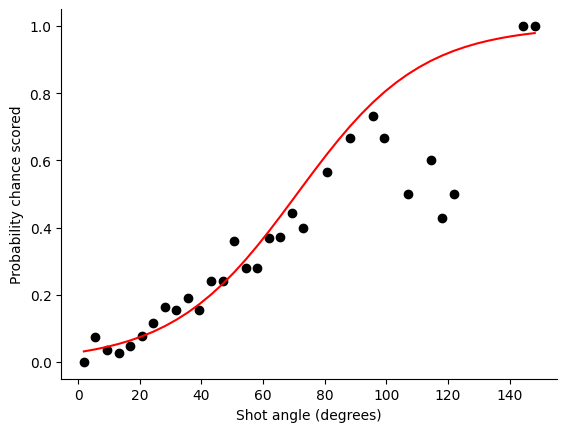

In [74]:
# Get best parameters
b = test_model.params

# Calculate xG
xGprob = 1/(1+np.exp(b[0]+b[1]*midangle*np.pi/180))

# Plot data
fig, ax = plt.subplots()
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')

# Plot logistic regression
ax.plot(midangle, xGprob, linestyle='solid', color='red')

# Make legend
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# Investigating the relationship between probability of scoring and distance to goal

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8451
Model:                                GLM   Df Residuals:                     8449
Model Family:                    Binomial   Df Model:                            1
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2524.4
Date:                    Sun, 04 May 2025   Deviance:                       5048.9
Time:                            16:51:06   Pearson chi2:                 1.56e+04
No. Iterations:                         6   Pseudo R-squ. (CS):            0.08410
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

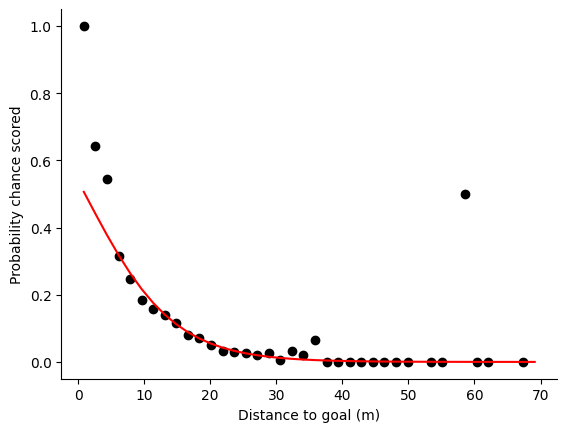

In [ ]:
# Binning data
shotcount_dist = np.histogram(shots['Distance'], bins=40, range=[0, 70])
goalcount_dist = np.histogram(goals['Distance'], bins=40, range=[0, 70])

# Probability of scoring goal
prob_goal = np.divide(goalcount_dist[0], shotcount_dist[0])
distance = shotcount_dist[1]
middistance = (distance[:-1] + distance[1:])/2

# Make plot
fig, ax = plt.subplots()
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')

# Make legend
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance to goal (m)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Make single variable model
test_model = smf.glm(formula="Goal ~ Distance" , data=shots, family=sm.families.Binomial()).fit()
print(test_model.summary())

# Get best parameters
b = test_model.params

# Calculate xG
xGprob = 1/(1+np.exp(b[0]+b[1]*middistance))

# Plot line
ax.plot(middistance, xGprob, linestyle='solid', color='red')

plt.show()

# The model looks ok: big probability of scoring a goal at low distance and decreasing probability at higher distances.
# But the probability of scoring a goal at 0m is 0.5, which is not way to low.

# Adding distance squared to the model

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8451
Model:                                GLM   Df Residuals:                     8448
Model Family:                    Binomial   Df Model:                            2
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2505.6
Date:                    Sun, 04 May 2025   Deviance:                       5011.1
Time:                            16:56:02   Pearson chi2:                 8.44e+03
No. Iterations:                         7   Pseudo R-squ. (CS):            0.08818
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

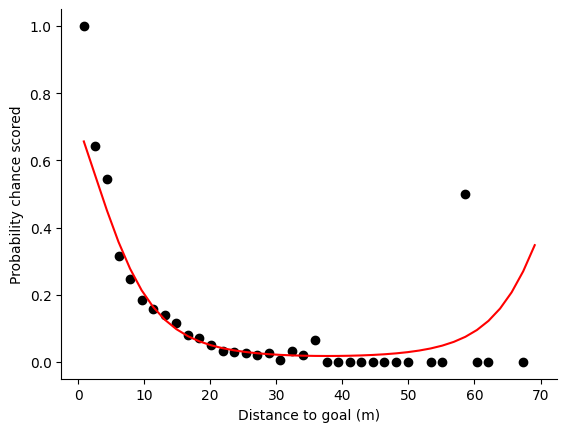

In [ ]:
# Calculate distance squared
shots["D2"] = shots["Distance"]**2

# Create model
test_model = smf.glm(formula="Goal ~ Distance + D2" , data=shots, family=sm.families.Binomial()).fit()
print(test_model.summary())

# Get best parameters
b = test_model.params

# Calculate xG
xGprob = 1/(1+np.exp(b[0]+b[1]*middistance+b[2]*middistance**2))

# Plot figure and line
fig, ax = plt.subplots()
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')
ax.plot(middistance, xGprob, linestyle='solid', color='red')

# Make legend
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance to goal (m)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# Model is a bit better at the start but shots from 0m should still get a bigger xG. 
# The model is wrong at the end by saying that the probability of scoring a goal is growing again from 30-40m and onwards.

# Adding squared variables to our model

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8451
Model:                                GLM   Df Residuals:                     8443
Model Family:                    Binomial   Df Model:                            7
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2498.7
Date:                    Sun, 04 May 2025   Deviance:                       4997.4
Time:                            17:20:23   Pearson chi2:                 8.40e+03
No. Iterations:                         7   Pseudo R-squ. (CS):            0.08966
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

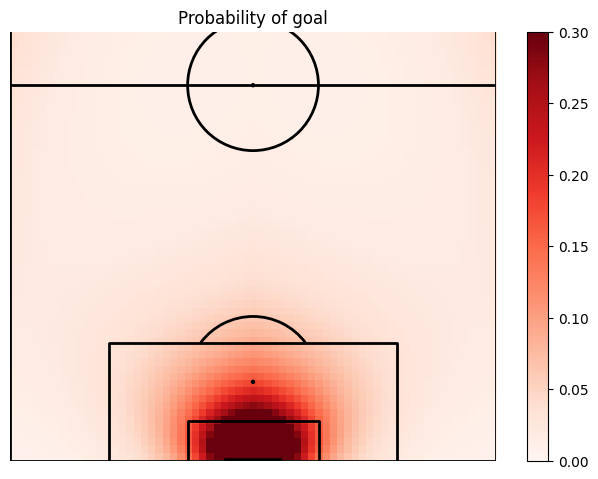

In [79]:
# Creating extra variables
shots["X2"] = shots["X"]**2
shots["Y2"] = shots["Y"]**2
shots["C2"] = shots["C"]**2
shots["AX"]  = shots['Angle']*shots['X']

# List the model variables
model_variables = ['Angle','Distance','X','C', "X2", "C2", "AX"]
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

# Fit the model
test_model = smf.glm(formula="Goal ~ " + model , data=shots, family=sm.families.Binomial()).fit()
print(test_model.summary())

# Get best parameters
b = test_model.params

# Return xG value a shot based on the variables listed in model_variables
def calculate_xG(sh):
   bsum=b[0]
   for i,v in enumerate(model_variables):
       bsum=bsum+b[i+1]*sh[v]
   xG = 1/(1+np.exp(bsum))
   return xG

# Add xG values for each shot
xG=shots.apply(calculate_xG, axis=1)
shots = shots.assign(xG=xG)

#Create a 2D map of xG
pgoal_2d=np.zeros((68,68)) # Creates a 68x68 grid
# For each point in the grid (x, y):
for x in range(68):
    for y in range(68):
        sh=dict()
        # Calculate the angle of the shot
        a = np.arctan(7.32 *x /(x**2 + abs(y-68/2)**2 - (7.32/2)**2))
        if a<0:
            a = np.pi + a
        sh['Angle'] = a

        # Calculate the distance of the shot
        sh['Distance'] = np.sqrt(x**2 + abs(y-68/2)**2)
        
        # Calculate other variables
        sh['D2'] = x**2 + abs(y-68/2)**2
        sh['X'] = x
        sh['AX'] = x*a
        sh['X2'] = x**2
        sh['C'] = abs(y-68/2)
        sh['C2'] = (y-68/2)**2

        # Calculate xG for the shot
        pgoal_2d[x,y] =  calculate_xG(sh)

# Plot the 2D xG map
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.draw()

# Plot the probability
pos = ax.imshow(pgoal_2d, extent=[-1,68,68,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.3, zorder = 1)
fig.colorbar(pos, ax=ax)

# Make legend
ax.set_title('Probability of goal')
plt.xlim((0,68))
plt.ylim((0,60))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Testing fit

Mcfaddens Rsquared 0.13708006325049116


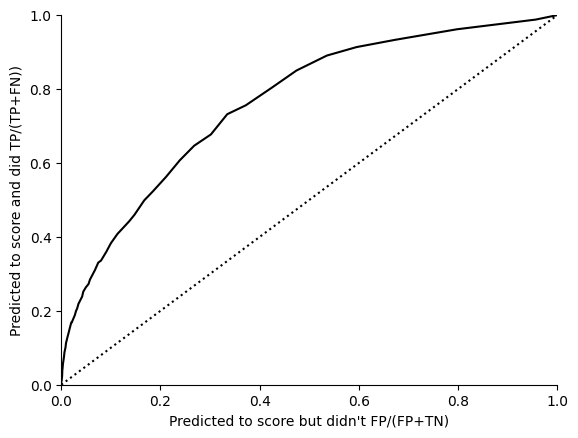

In [80]:
# Mcfaddens Rsquared for Logistic regression
null_model = smf.glm(formula="Goal ~ 1 ", data=shots, family=sm.families.Binomial()).fit()
print("Mcfaddens Rsquared", 1 - test_model.llf / null_model.llf)

# R^2 = 0 -> no better fit than predicting the average
# R^2 = 1 -> perfect fit
# R^2 = 0.2 - 0.4 -> good fit

# ROC curve
numobs = 100
TP = np.zeros(numobs) # True Positives: correctly predicted goals
FP = np.zeros(numobs) # False Positives: incorrectly predicted goals
TN = np.zeros(numobs) # True Negatives: correctly predicted non-goals
FN = np.zeros(numobs) # False Negatives: incorrectly predicted non-goals

# Testing 100 thresholds from 0 to 1
for i, threshold in enumerate(np.arange(0, 1, 1 / numobs)):
    for j, shot in shots.iterrows():
        if (shot['Goal'] == 1):
            if (shot['xG'] > threshold):
                TP[i] = TP[i] + 1
            else:
                FN[i] = FN[i] + 1
        if (shot['Goal'] == 0):
            if (shot['xG'] > threshold):
                FP[i] = FP[i] + 1
            else:
                TN[i] = TN[i] + 1

fig, ax = plt.subplots()
ax.plot(FP / (FP + TN), TP / (TP + FN), color='black') # True positive rate (TPR) vs False positive rate (FPR) for model
ax.plot([0, 1], [0, 1], linestyle='dotted', color='black') # random guessing line (50% chance of scoring)


ax.set_ylabel("Predicted to score and did TP/(TP+FN))")
ax.set_xlabel("Predicted to score but didn't FP/(FP+TN)")
plt.ylim((0.00, 1.00))
plt.xlim((0.00, 1.00))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Hoe beter het model
# - hoe meer de curve naar boven links gaat
# - hoe groter de oppervlakte onder de curve is